In [124]:
# ==================================================================
# Script to analyse tractography-related statistics
# ==================================================================
import os
import sys
import glob #for wildcard matching
import collections #for ordered dictionary
import time
import subprocess
import nibabel as nib
import numpy as np

In [125]:
"""Anthony's notes
- modules that needs to be loaded:
    - qbatch/git
    - FSL

- during the initiation of the idx and pct file paths, it is ASSUMED that all input paths will:
    - have a perfect correspondence of pct to idx paths for each subject
        - both will appear in the same ordered after being sorted in the lists
    - the second-to-last part deliminated by "/" will be the subject ID for both files
- input file path assumptions
    - there will be no period character (".") OTHER than for at the end
    - there are two total period characters: "filename.nii.gz"
"""
print "All is well"

All is well


In [131]:
# ==================================================================
# Setup files and directories
# ==================================================================

""" Note on directory hierarchy for the input, reference and transform files 
parent_dir
    |
    +-- subj_dir_1 (as indicated by dir_wc)
    |        |
    |        +- file_of_interest (as indicated by *_file_name)
    |
    +-- subj_dir_2 ...
"""

#Variable indication how many component parcellation we want to use
SEG_NUM = 5
# ========================================
# Input files for fslmaths and fslstats
# ========================================
in_parent_dir='/data/chamal/projects/raihaan/HCP/HCP900/group-avg/900-t1-t2/300-unrl/native/comp_prob_newMasks/'
in_dir_wc='[0-9][0-9][0-9][0-9][0-9][0-9]/warped/'
lab_file_name = 'fa_x07_lefthc.nii.gz'
idx_file_name = '*_comp'+str(SEG_NUM)+"_seg_idx_warped.nii.gz"
pct_file_name = '*_comp'+str(SEG_NUM)+"_seg_pct_warped.nii.gz"

# ========================================
# Intermediate files
# ========================================
inter_parent_dir='/data/chamal/projects/anthony/Rai_Tract_Analysis/'+str(SEG_NUM)+'comp_parcellation'
csvDump_filename="seg"+str(SEG_NUM)+"_avgComponentWinPct_dump.csv"

# ========================================
# JobDoc files
# ========================================
jobDoc_dir='/data/chamal/projects/anthony/Rai_Tract_Analysis/qbatch_docs/'
jobList_path_head=os.path.join(jobDoc_dir,'autoSubmit_seg%d_tract_compWinPct'%SEG_NUM)

In [132]:
# ==================================================================
# Initiate paths of the two input files
# ==================================================================
"""Dictionary hierarchy
subjFile_Paths
    |
    ["100307"]
    |    |
    |    ["idx"] -- path to 100307's idx file
    |    ["pct"] -- path to 100307's pct file
    |
    ["100408"]
    ...
"""
#Find all files on paths
lab_file_list=glob.glob(os.path.join(in_parent_dir,in_dir_wc,lab_file_name))
idx_file_list=glob.glob(os.path.join(in_parent_dir,in_dir_wc,idx_file_name))
pct_file_list=glob.glob(os.path.join(in_parent_dir,in_dir_wc,pct_file_name))
#Sort the two lists
lab_file_list.sort()
idx_file_list.sort()
pct_file_list.sort()
#Store the two files into a sorted dictionary
subjFile_paths = collections.OrderedDict([]) #Initiate ordered dictionary
for lab_file_path, idx_file_path, pct_file_path in zip(lab_file_list, idx_file_list, pct_file_list):
    #Store the file paths in a temp dictionary
    temp_dict = {}
    temp_dict['label'] = lab_file_path
    temp_dict['idx'] = idx_file_path
    temp_dict['pct'] = pct_file_path
    #Check for subject ID and that they match up
    temp_subj_ID = idx_file_path.split('/')[-3] #TODO: change to -2 after finishing Rai's files
    #Check if the two file IDs do not match
    if pct_file_path.split('/')[-3] != temp_subj_ID: #TODO: change to -2 after finishing Rai's files
        print "Something went wrong in the pct and idx file matching for ID: %s" % (temp_subj_ID)
    #Add the temporary dictionary to the sorted dictionary
    subjFile_paths[temp_subj_ID] = temp_dict

#Let user know 
print "The parcellation component quantity is: %d" % SEG_NUM
print "lab_file_list length: %d" % len(lab_file_list)
print "idx_file_list length: %d" % len(idx_file_list)
print "pct_file_list length: %d" % len(pct_file_list)
print "\n%d subjects were initiated into the subjFile_Paths dictionary:" % len(subjFile_paths)
for key in subjFile_paths:
    print key,
print "\n\nHopefully the above looks right!"

The parcellation component quantity is: 5
lab_file_list length: 100
idx_file_list length: 100
pct_file_list length: 100

100 subjects were initiated into the subjFile_Paths dictionary:
100307 100408 101006 101107 101410 101915 102008 102311 102816 103111 105014 105115 105216 106016 106521 107321 107422 108121 108323 108525 109123 110411 111312 111413 111716 113215 113821 113922 114419 115320 116524 117122 118528 118730 118932 119833 120212 120515 121618 122317 122620 123117 123420 123925 124422 125525 126325 126628 127630 127933 128127 128632 129028 130013 130316 131217 131722 132118 133019 133827 134324 135225 135528 136227 136833 137027 138534 139233 140925 144832 146432 147030 147737 148840 148941 149741 150423 150524 150726 151223 151526 151627 151728 153833 154734 154835 154936 156233 156637 157437 158136 159239 159340 160830 161327 161630 162228 162733 163331 164030 

Hopefully the above looks right!


In [133]:
# ==================================================================
# Generate the jobs needed to calculate everyone's component average
# ==================================================================

#Check to see if the output parent directory is present, if not create it
if os.path.isdir(inter_parent_dir):
    print "Intermediate directory found: %s" % inter_parent_dir
else:
    os.mkdir(inter_parent_dir)
    print "Intermediate directory not found, created one at: %s"% inter_parent_dir

#Create the path to the .csv file to dump all of the pct averages
csvDump_path_tail = os.path.join(inter_parent_dir, csvDump_filename)

#Create the paths to the 5 sequential files needed to get the mean
binvLabel_outPath = jobList_path_head + "_pt1-binvLabel.sub"
pctNoThalamus_outPath = jobList_path_head + "_pt2-pctNoThalamus.sub"
binLabelComp_outPath = jobList_path_head + "_pt3-binLabelComp.sub"
pctComp_outPath = jobList_path_head + "_pt4-pctComp.sub"
avgCompPct_outPath = jobList_path_head + "_pt5-avgCompPct.sub"

#Open the jobList document to write to
print "\nOpening and writing to joblist files: %s" % jobList_path_head
binvLabel_out = open(binvLabel_outPath, 'w')
pctNoThalamus_out = open(pctNoThalamus_outPath, 'w')
binLabelComp_out = open(binLabelComp_outPath, 'w')
pctComp_out = open(pctComp_outPath, 'w')
avgCompPct_out = open(avgCompPct_outPath, 'w')

#Lists to store all generated file paths for later reference (during auto-submission)
binvLabel_path_list = []
pct_noThalamus_path_list = []
binarizedComp_path_list = []
pct_comp_path_list = []
indv_csv_path_list = []

#Iterate through each subject
for subj in subjFile_paths:
    #Check to see if the output directory is present, if not create it
    subj_dir_path = os.path.join(inter_parent_dir, subj)
    if not os.path.isdir(subj_dir_path):
        os.mkdir(subj_dir_path)
        
    #Generate an individual csv file for this subject
    csvDump_path = os.path.join(inter_parent_dir, str(subj)+"_indv_"+csvDump_filename)
    #Store the path to the csv file for later reference
    indv_csv_path_list.append(csvDump_path)
    
    #Get the input files
    labelPath = subjFile_paths[subj]['label']
    idxPath = subjFile_paths[subj]['idx']
    pctPath = subjFile_paths[subj]['pct']
    
    ###### Part 1 & 2: generate pct files with the thalamus region removed ######
    #Generate the subject-specific job files paths
    subj_binvLabel_name = labelPath.split('/')[-1].split('.')[0]+"_binv.nii.gz"
    subj_binvLabel_outPath = os.path.join(subj_dir_path, subj_binvLabel_name)
    pctNoThal_name = pctPath.split('/')[-1].split('.')[0]+"_noThalamus.nii.gz"
    pctNoThal_outPath = os.path.join(subj_dir_path, pctNoThal_name)
    
    #Keep record of the file paths
    binvLabel_path_list.append(subj_binvLabel_outPath)
    pct_noThalamus_path_list.append(pctNoThal_outPath)
    
    #Generate the fslcommands
    binvLabel = 'fslmaths %s -binv %s' % (labelPath, subj_binvLabel_outPath)
    pctNoThal = 'fslmaths %s -mul %s %s' % (pctPath, subj_binvLabel_outPath, pctNoThal_outPath)
    
    #Write to respective job documents
    binvLabel_out.write(binvLabel+"\n")
    pctNoThalamus_out.write(pctNoThal+"\n")
    ############################################################################
    
    #Iterate through each component
    for comp_num in range(1,SEG_NUM+1):
        ######### Part 3-5: generate pct files for individual components #########
        #Generate the component-specific job file paths
        binarizedComp_name = idxPath.split('/')[-1].split('.')[0]+"_comp"+str(comp_num)+"_binarized.nii.gz"
        binarizedComp_outPath = os.path.join(subj_dir_path, binarizedComp_name )
        pct_comp_name = pctNoThal_outPath.split('/')[-1].split('.')[0]+"_comp"+str(comp_num)+".nii.gz"
        pct_comp_outPath = os.path.join(subj_dir_path, pct_comp_name )
        
        #Store the paths in reference lists
        binarizedComp_path_list.append(binarizedComp_outPath)
        pct_comp_path_list.append(pct_comp_outPath)
        
        #Generate the fsl commands
        binarization='fslmaths %s -thr %d -thr %d -bin %s' % (idxPath, comp_num,comp_num, binarizedComp_outPath)
        multiplication='fslmaths %s -mul %s %s' % (pctNoThal_outPath, binarizedComp_outPath, pct_comp_outPath)
        calAvg='echo "%s,%s,`fslstats %s -M`" >> %s' % (subj, "comp_"+str(comp_num), pct_comp_outPath, csvDump_path)
        
        #Write the commands to the jobList file
        binLabelComp_out.write(binarization+"\n")
        pctComp_out.write(multiplication+"\n")
        avgCompPct_out.write(calAvg+"\n")
        ############################################################################


#Close the jobList output stream
binvLabel_out.close()
pctNoThalamus_out.close()
binLabelComp_out.close()
pctComp_out.close()
avgCompPct_out.close()

#Indicate to user
print "\nFinished writing to joblist file"
print "\nReference lists created:"
print "\tbinvLabel_path_list - length: %d" % len(binvLabel_path_list)
print "\tpct_noThalamus_path_list - length: %d" % len(pct_noThalamus_path_list)
print "\tbinarizedComp_path_list - length: %d" % len(binarizedComp_path_list)
print "\tpct_comp_path_list - length: %d" % len(pct_comp_path_list)
print "\tindv_csv_path_list - length: %d" % len(indv_csv_path_list)

Intermediate directory not found, created one at: /data/chamal/projects/anthony/Rai_Tract_Analysis/5comp_parcellation

Opening and writing to joblist files: /data/chamal/projects/anthony/Rai_Tract_Analysis/qbatch_docs/autoSubmit_seg5_tract_compWinPct

Finished writing to joblist file

Reference lists created:
	binvLabel_path_list - length: 100
	pct_noThalamus_path_list - length: 100
	binarizedComp_path_list - length: 500
	pct_comp_path_list - length: 500
	indv_csv_path_list - length: 100


In [134]:
# ==================================================================
# Optionally submit the job sequentially to the cluster
# ==================================================================

######## Qbatch specifics ########
SUBMIT = True
QSUB = True
#For the 1st and 2nd job (normal)
CHUNKSIZE = '1' #Need each 3 lines to run sequentially
WALLTIME = '00:30:00'
#For the 3rd job
CHUNKSIZE_3 = str(SEG_NUM) #Each job will be for individual subjects
PPJ_3 = "4" #Needs more memory than usual
"""This should take ~2min per line, so each job should be SEG_NUM*2min long? (guesstimated, may be shorter)"""


#Function to wait until the previous step has been completed
def waitLoop(prev_output_paths):
    #Infinite loop
    while True:
        #Check if all output files from previous step is present
        allFilesPresent = True
        for path in prev_output_paths:
            if os.path.isfile(path) != True:
                allFilesPresent = False
        #Either break loop or continue waiting
        if allFilesPresent:
            break
        else:
            time.sleep(2) #Currently checks every 2 seconds
    print "All output files from previous step found!"
            
"""Reference temp
binvLabel_outPath 
pctNoThalamus_outPath 
binLabelComp_outPath 
pctComp_outPath 
avgCompPct_outPath

binvLabel_path_list = []
pct_noThalamus_path_list = []
binarizedComp_path_list = []
pct_comp_path_list = []
indv_csv_path_list = []
"""
#Automatically submit all 3 jobList files sequentially
if SUBMIT:
    ######## Step 1: submit the binv label files ########
    print "Submitting label binarize-inverse job (step 1)"
    if QSUB:
        cmd = ['qbatch', '-w', WALLTIME, '-c', CHUNKSIZE, binvLabel_outPath]
    else:
        cmd = ['bash', binvLabel_outPath]
    print ' '.join(cmd)
    subprocess.call(cmd)
    
    ######## Step 2: submit the noThalamus pct files ########
    #Wait until the previous jobs have been completed
    print "\nWaiting for step 1 to finish..."
    waitLoop(binvLabel_path_list)
    #Submit step 2
    print "Submitting thalamus removal from pct file step (step 2):"
    if QSUB:
        cmd = ['qbatch','-w',WALLTIME, '-c',CHUNKSIZE, '--ppj', '2', pctNoThalamus_outPath]
    else:
        cmd = ['bash', pctNoThalamus_outPath]
    print ' '.join(cmd)
    subprocess.call(cmd)
    
    ######## Step 3: submit the component binarization files ########
    #Wait until the previous jobs have been completed
    print "\nWaiting for step 2 to finish..."
    waitLoop(pct_noThalamus_path_list)
    #Submit step 3
    print "Submitting component binarization job (step 3):"
    if QSUB:
        cmd = ['qbatch','-w',WALLTIME, '-c',CHUNKSIZE, binLabelComp_outPath]
    else:
        cmd = ['bash', binLabelComp_outPath]
    print ' '.join(cmd)
    subprocess.call(cmd)
    
    ####### Step 4: submit the multiplciation files #######
    #Wait until the previous jobs have been completed
    print "\nWaiting for step 3 to finish..."
    waitLoop(binarizedComp_path_list)
    #Submit step 4
    print "\nSubmitting multiplication job (step 4):"
    if QSUB:
        cmd = ['qbatch','-w',WALLTIME, '-c',CHUNKSIZE, pctComp_outPath]
    else:
        cmd = ['bash', pctComp_outPath]
    print ' '.join(cmd)
    subprocess.call(cmd)
    
    #sys.exit() #TODO: temp solution because the last steps always messes up
                #Will do last submission locally manually
    
    ####### Step 5: submit the fslstats average calculation #######
    #Wait until the previous jobs have been completed
    print "\nWaiting for step 4 to finish..."
    waitLoop(pct_comp_path_list)
    ##### temp resolution to core dump bug #####
    print "Step 4 done. Submit step 5 manually with a lot of cores or run locally"
    sys.exit()
    ############################################
    #Submit step 5
    print "\nSubmitting average calculation job (step 5):"
    if QSUB:
        cmd = ['qbatch', '-c', CHUNKSIZE_3, '--ppj', PPJ_3, avgCompPct_outPath]
    else:
        cmd = ['bash', avgCompPct_outPath]
    print ' '.join(cmd)
    subprocess.call(cmd)
    print
else:
    print "Auto-submit not enabled. Skipping over current code block."
    

print "Done"    

Submitting label binarize-inverse job (step 1)
qbatch -w 00:30:00 -c 1 /data/chamal/projects/anthony/Rai_Tract_Analysis/qbatch_docs/autoSubmit_seg5_tract_compWinPct_pt1-binvLabel.sub

Waiting for step 1 to finish...
All output files from previous step found!
Submitting thalamus removal from pct file step (step 2):
qbatch -w 00:30:00 -c 1 --ppj 2 /data/chamal/projects/anthony/Rai_Tract_Analysis/qbatch_docs/autoSubmit_seg5_tract_compWinPct_pt2-pctNoThalamus.sub

Waiting for step 2 to finish...
All output files from previous step found!
Submitting component binarization job (step 3):
qbatch -w 00:30:00 -c 1 /data/chamal/projects/anthony/Rai_Tract_Analysis/qbatch_docs/autoSubmit_seg5_tract_compWinPct_pt3-binLabelComp.sub

Waiting for step 3 to finish...
All output files from previous step found!

Submitting multiplication job (step 4):
qbatch -w 00:30:00 -c 1 /data/chamal/projects/anthony/Rai_Tract_Analysis/qbatch_docs/autoSubmit_seg5_tract_compWinPct_pt4-pctComp.sub

Waiting for step 4 to

SystemExit: 

In [78]:
binvLabel_path_list[0]

'/data/chamal/projects/anthony/qbatch_jobDocs/track_analysis_related/autoSubmit_seg8_tract_compWinPct_pt1-binvLabel.sub'

In [97]:
####################################################################
# ==================================================================
""" =================== DEPENDENCY SEPARATOR =================== """
# ==================================================================
####################################################################
print "The below block is independent, other than for the first (module import) block"

The below block is independent, other than for the first (module import) block


In [159]:
# ==================================================================
# Set up input directories and paths
# *currently dependent on the prev file input block
# *can simply take away the right-hand-side variables for manual input
# ==================================================================
"""Notes on file formats
- The 2nd col of the .csv file ALWAYS specifies the component #
    - Specified as a string
    - Needs to be the same for all subj's same components
- The 3rd col of the .csv file ALWAYS specifies the mean
    - It needs to be able to be converted to a float
"""
#Additional imports
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#specify parcellation quantity
SEG_NUM = 6

#Paths set-up
indv_csv_dir = '/data/chamal/projects/anthony/nmf_parcellation/cortical_tractMap/seg'+str(SEG_NUM)+'_tract2voxel_probability_labels/tractAnalysis_model_space'
indv_csv_wc = "*seg"+str(SEG_NUM)+"_avgComponentWinPct_dump.csv"

# ==================================================================
# Find and initiate input files
# ==================================================================

#Locate and sort file paths 
indv_csv_paths = glob.glob(os.path.join(indv_csv_dir, indv_csv_wc))
indv_csv_paths.sort()

print "File paths found: %d" % len(indv_csv_paths)
print "\nFirst path is: %s" % indv_csv_paths[0]
print "\nLast path is: %s" % indv_csv_paths[-1]

File paths found: 100

First path is: /data/chamal/projects/anthony/nmf_parcellation/cortical_tractMap/seg6_tract2voxel_probability_labels/tractAnalysis_model_space/100307_indv_seg6_avgComponentWinPct_dump.csv

Last path is: /data/chamal/projects/anthony/nmf_parcellation/cortical_tractMap/seg6_tract2voxel_probability_labels/tractAnalysis_model_space/164030_indv_seg6_avgComponentWinPct_dump.csv


In [160]:
# ==================================================================
# Find and initiate input files
# ==================================================================
"""Variable hierarchy
tractWinPct
    |
    [0]-- component 1's tract win pct
            (this is a list of average winPct in float)
"""

#Initiate a dictionary 
tractWinPct_unordered = {}

#Iterate through each subject's csv file
print "Initiating .csv file contents..."
for csv_path in indv_csv_paths:
    #Open the file and initate reader
    csvfile = open(csv_path, 'rb')
    reader = csv.reader(csvfile)
    #Iterate through each row of the csv file
    for row in reader:
        #If the component num has not been initiated, initiate the key
        if row[1] not in tractWinPct_unordered:
            tractWinPct_unordered[row[1]] = [float(row[2])]
        #Else, concatenate the mean onto the list
        else:
            tractWinPct_unordered[row[1]].append(float(row[2]))

#Initiate a sorted dictionary
print "Sorting component lexographically..."
tractWinPct = collections.OrderedDict(sorted(tractWinPct_unordered.items()))

#Let user know
print "\nDone. Below are the components and length of lists for each:"
for key in tractWinPct:
    print "\t%s\tLength: %d" % (key, len(tractWinPct[key]))

Initiating .csv file contents...
Sorting component lexographically...

Done. Below are the components and length of lists for each:
	comp_1	Length: 100
	comp_2	Length: 100
	comp_3	Length: 100
	comp_4	Length: 100
	comp_5	Length: 100
	comp_6	Length: 100


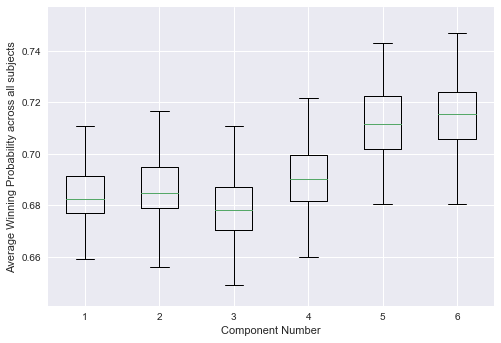

In [161]:
# ==================================================================
# Plots and shit
# ==================================================================
# Organize data
data = []
for key in tractWinPct:
    data.append(tractWinPct[key])


plt.figure()
#Set labels
plt.xlabel('Component Number')
plt.ylabel('Average Winning Probability across all subjects')
#Plot the data
plt.boxplot(data)
plt.show()

In [162]:
# ==================================================================
# Playing around with intermode contrast (Intermode contrast data is independent)
# ==================================================================

# Specify input file paths
starting_comp_num = 5
last_comp_num = 10

#Paths???
input_dir = "/data/chamal/projects/anthony/nmf_parcellation/nmf_scripts"


#Initialize dictionary for data
factorized_matrix = {}
# Import saved files
for comp_num in range(starting_comp_num, (last_comp_num+1) ):
    #Initialize matrix paths
    feature_path = os.path.join(input_dir, "matrix_files/seg%d_feature_matrix.npz"%(comp_num) )
    component_path = os.path.join(input_dir, "matrix_files/seg%d_component_matrix.npz"%(comp_num) )
    #Begin loading data
    current_data = {}
    print "Loading feature and component matrix for seg %d..." % (comp_num)
    with open(feature_path, 'rb') as feature_inStream:
        current_data['feature'] = np.load(feature_inStream)
    with open(component_path, 'rb') as component_inStream:
        current_data['component'] = np.load(component_inStream)
    #Inidiate to user matrix size and save in overall matrix
    print "\tFeature matrix shape:", np.shape(current_data['feature'])
    print "\tComponent matrix shape:", np.shape(current_data['component'])
    factorized_matrix[comp_num] = current_data

#Sort the dictionary
import collections
matrices = collections.OrderedDict(sorted(factorized_matrix.items()))
print "Matrices have been sorted in the following order:"
for key in matrices:
    print "\t",key

# ==================================================================
# Initializing intermode contrast data
# ==================================================================
imContrast = collections.OrderedDict()

#Iterate through each parcellated component number
for comp_num in matrices:
    #Initialize sub-matrix to store intermode contrast values
    comp_mat = matrices[comp_num]['component']
    col_length = np.shape(comp_mat)[1]
    temp_ic_mat = np.zeros((2,col_length))
    #Iterate through each column of the component matrices
    for col_idx in range(0,col_length):
        #Extract value
        col_max = comp_mat[:,col_idx].max() # Get max value 
        max_idx = np.argmax( comp_mat[:,col_idx] ) #Get max value index
        col_sum = np.sum(comp_mat[:,col_idx]) #Get sum of all weights
        #Calculate intermode contrast
        col_IC = col_max / col_sum
        #Add value to out matrix
        temp_ic_mat[0,col_idx] = col_IC
        temp_ic_mat[1,col_idx] = max_idx + 1 #+1 so that the label index starts form 1 instead of 0  
    #Add temp matrix to overall matrix
    imContrast[comp_num] = temp_ic_mat

print "Intermode contrast calculated!"
print "Keys are organized in the following fashion:"
for key in imContrast:
    print '\t',key

Loading feature and component matrix for seg 5...
	Feature matrix shape: (500, 5)
	Component matrix shape: (5, 16500)
Loading feature and component matrix for seg 6...
	Feature matrix shape: (500, 6)
	Component matrix shape: (6, 16500)
Loading feature and component matrix for seg 7...
	Feature matrix shape: (500, 7)
	Component matrix shape: (7, 16500)
Loading feature and component matrix for seg 8...
	Feature matrix shape: (500, 8)
	Component matrix shape: (8, 16500)
Loading feature and component matrix for seg 9...
	Feature matrix shape: (500, 9)
	Component matrix shape: (9, 16500)
Loading feature and component matrix for seg 10...
	Feature matrix shape: (500, 10)
	Component matrix shape: (10, 16500)
Matrices have been sorted in the following order:
	5
	6
	7
	8
	9
	10
Intermode contrast calculated!
Keys are organized in the following fashion:
	5
	6
	7
	8
	9
	10


In [171]:
# ==================================================================
# Organize and compare IC data
# ==================================================================

comp_indeces = [i for i in range(1,SEG_NUM+1)]

IC_data = [] #TODO rename this
#Iterate
for comp_idx in comp_indeces:
    small_data = [] #TODO rename this
    for col_idx in range(0,col_length):
        if imContrast[SEG_NUM][1,col_idx] == comp_idx:
            small_data.append(imContrast[SEG_NUM][0,col_idx])
    IC_data.append(small_data)

for j in range(0,SEG_NUM):
    IC_mean = sum(IC_data[j]) / len(IC_data[j])
    tractProb_mean = sum(data[j])/len(data[j])
    print tractProb_mean / IC_mean

    #Note: normalize to the same range then do ratio?

2.82113786601
2.33719250222
2.52811682291
2.13544527599
2.10004112151
2.32146629156
